# ECCO Data - cleaned version
Bottom Temperature and Salinity to compare with SOSE and WOA products

In [3]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [8]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.807566a0a67f4a799d29af0327402387/status,


In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
%matplotlib inline
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
#import plot_proj_to_latlon_grid

In [2]:
from intake import open_catalog

cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds  = cat["ECCOv4r3"].to_dask()

In [4]:
ds_ll = faces_dataset_to_latlon(ds)

In [5]:
# a trick to make things work a bit faster
coords_before_drop = ds_ll.coords.to_dataset().reset_coords().roll(i=50, i_g=50)
ds_before_drop = ds_ll.reset_coords(drop=True).roll(i=50, i_g=50)

In [6]:
coords = coords_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])
ds = ds_before_drop.drop(['i', 'j', 'i_g', 'j_g', 'k_u', 'k_l', 'k_p1'])

In [7]:
coords.hFacC

<xarray.DataArray 'hFacC' (k: 50, j: 270, i: 360)>
dask.array<rechunk-merge, shape=(50, 270, 360), dtype=float32, chunksize=(50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i
Attributes:
    long_name:      vertical fraction of open cell
    standard_name:  cell_vertical_fraction

In [9]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
left_lon = 23 #~-64.5˚ #used to be 20
right_lon = 118 #30.5˚ #used to be 115
lower_lat = 30 #~-80˚ #used to be 38
upper_lat = 80 #-61.755745˚ instead of #79:-62.216576˚ to fill upper projection plot row

In [10]:
#set the boundaries
lat_range = dict(j=slice(lower_lat, upper_lat))
lon_range = dict(i=slice(left_lon, right_lon))

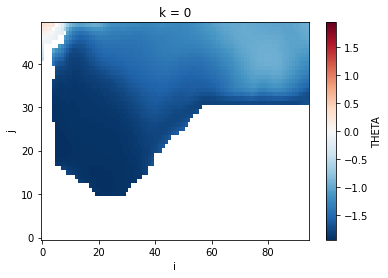

In [11]:
#testing to see if correctly sliced desired region
sst_mean = ds.THETA.sel(**lat_range, **lon_range).sel(k=0).mean(dim='time')
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0)
sst_mean.where(surface_mask).plot()

## <span style='color:Brown'> Bottom Potential Temperatures

In [10]:
coords.hFacC

<xarray.DataArray 'hFacC' (k: 50, j: 270, i: 360)>
dask.array<rechunk-merge, shape=(50, 270, 360), dtype=float32, chunksize=(50, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: j, i
Attributes:
    long_name:      vertical fraction of open cell
    standard_name:  cell_vertical_fraction

In [12]:
#this gives us the depth of the bottom cell
depth_max = ds.k.where(coords.hFacC > 0).max(dim='k').load()

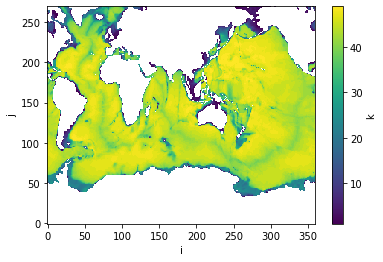

In [13]:
depth_max.plot()

In [14]:
bottom_temp = ds.THETA.isel(k=depth_max.fillna(0.).astype('i4'))
bottom_temp_wg = bottom_temp.isel(**lat_range, **lon_range).load()

In [15]:
bottom_temp_wg_mean = bottom_temp_wg.mean(dim='time').load()

In [16]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

In [17]:
bottom_temp_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_temp_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)

In [18]:
bottom_temp_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_temp_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)
bottom_temp_wg_mean

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5656109 ,  1.8291065 ,  1.6809775 , ..., -0.60746783,
        -0.60745776, -0.6074615 ],
       [ 0.13080378,  0.25096482,  1.8400244 , ..., -0.60863906,
        -0.6083164 , -0.608207  ],
       [ 0.12459682,  0.0798245 ,  0.19863093, ..., -0.61016595,
        -0.6093797 , -0.60912585]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117

In [19]:
lon = coords_before_drop.XC.isel(**lon_range, **lat_range)
lat = coords_before_drop.YC.isel(**lat_range, **lon_range)

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


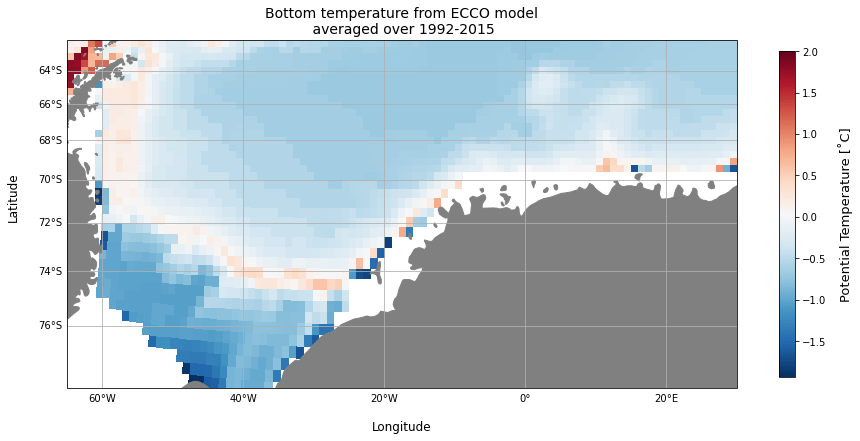

In [22]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_temp_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from ECCO model\n averaged over 1992-2015', fontsize=14)
plt.savefig('bot-temp-ecco.pdf');

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [23]:
bottom_std_temp = ds.THETA.isel(k=depth_max.fillna(0.).astype('i4')).std('time')
bottom_std_temp_wg = bottom_std_temp.isel(**lat_range, **lon_range)

In [24]:
bottom_std_temp_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_std_temp_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)
bottom_std_temp_wg

<xarray.DataArray 'THETA' (j: 50, i: 95)>
dask.array<getitem, shape=(50, 95), dtype=float32, chunksize=(50, 95), chunktype=numpy.ndarray>
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>

In [25]:
bottom_std_temp_wg.load()

<xarray.DataArray 'THETA' (j: 50, i: 95)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07491323, 0.03105013, 0.08613247, ..., 0.02001635, 0.01984921,
        0.01967735],
       [0.10633206, 0.08333268, 0.0289332 , ..., 0.02005466, 0.01991507,
        0.01977147],
       [0.10318091, 0.11221348, 0.09422934, ..., 0.02019693, 0.02006324,
        0.0199395 ]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


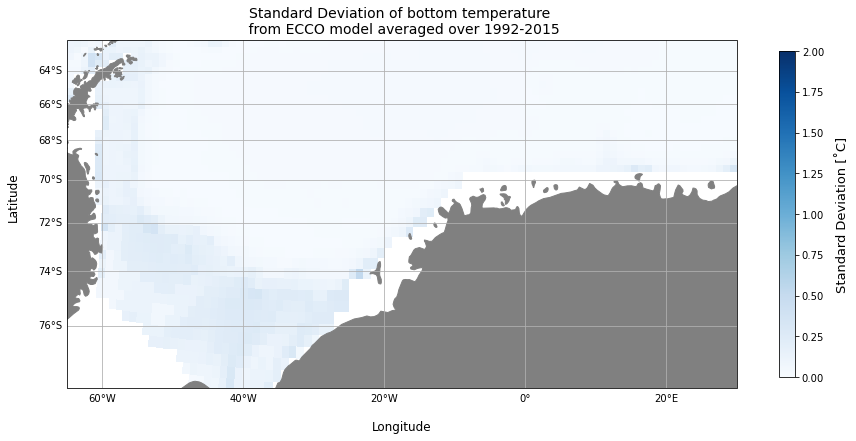

In [27]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_std_temp_wg.where(surface_mask), transform=ccrs.PlateCarree(), 
                   cmap='Blues', vmin=0, vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation of bottom temperature \n from ECCO model averaged over 1992-2015', fontsize=14)
plt.savefig('std-bot-temp-ecco.pdf');

## <span style='color:Red'> Bottom Temperature Deviation (end)

## <span style='color:Red'> Bottom Temperature Z-score (start)

## Bottom Salinity

In [28]:
bottom_slt = ds.SALT.isel(k=depth_max.fillna(0.).astype('i4'))

In [29]:
bottom_slt_wg = bottom_slt.isel(**lat_range, **lon_range).load()

In [30]:
bottom_slt_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_slt_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)

In [31]:
bottom_slt_wg_mean = bottom_slt_wg.mean(dim='time').load()

In [32]:
bottom_slt_wg_mean['j'] = coords_before_drop.j.isel(**lat_range)
bottom_slt_wg_mean['i'] = coords_before_drop.i.isel(**lon_range)
bottom_slt_wg_mean

<xarray.DataArray 'SALT' (j: 50, i: 95)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [34.712536, 34.676   , 34.642563, ..., 34.6691  , 34.668694,
        34.66834 ],
       [34.702305, 34.706024, 34.67171 , ..., 34.669205, 34.668774,
        34.66839 ],
       [34.702038, 34.700333, 34.704147, ..., 34.66935 , 34.668922,
        34.668484]], dtype=float32)
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 -80.07 -80.14 -80.21 -80.27 ... -62.22 -62.22 -62.22
    lon      (j, i) float32 -71.48 -70.46 -69.43 -68.39 ... 26.5 27.5 28.5 29.5

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


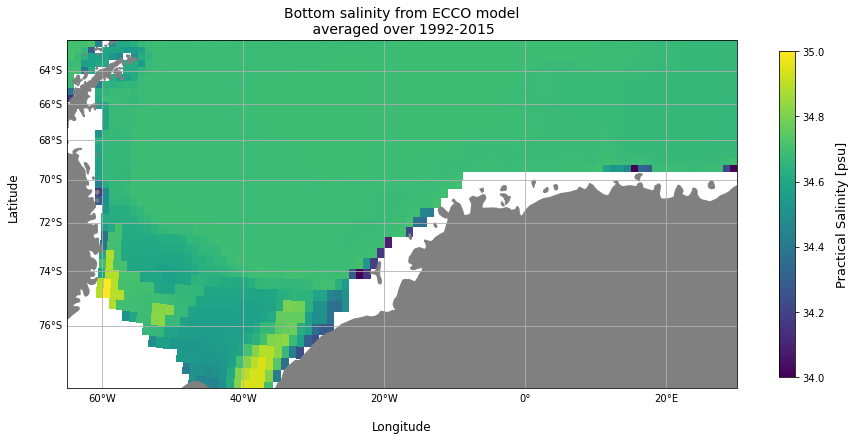

In [37]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_slt_wg_mean.where(surface_mask), transform=ccrs.PlateCarree(), cmap='viridis', vmin=34, vmax=35)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Practical Salinity [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from ECCO model\n averaged over 1992-2015', fontsize=14)
plt.savefig('bot-salt-ecco.pdf');

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [34]:
bottom_std_slt = ds.SALT.isel(k=depth_max.fillna(0.).astype('i4')).std('time')
bottom_std_slt_wg = bottom_std_slt.isel(**lat_range, **lon_range)

In [35]:
bottom_std_slt_wg['lat'] = coords_before_drop.YC.isel(**lat_range, **lon_range)
bottom_std_slt_wg['lon'] = coords_before_drop.XC.isel(**lon_range, **lat_range)
bottom_std_slt_wg

<xarray.DataArray 'SALT' (j: 50, i: 95)>
dask.array<getitem, shape=(50, 95), dtype=float32, chunksize=(50, 95), chunktype=numpy.ndarray>
Coordinates:
    k        (j, i) int64 0 0 0 0 0 0 0 0 0 0 ... 47 47 47 47 47 47 47 47 47 47
  * i        (i) int64 23 24 25 26 27 28 29 30 ... 111 112 113 114 115 116 117
  * j        (j) int64 30 31 32 33 34 35 36 37 38 ... 71 72 73 74 75 76 77 78 79
    lat      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>
    lon      (j, i) float32 dask.array<chunksize=(50, 67), meta=np.ndarray>

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


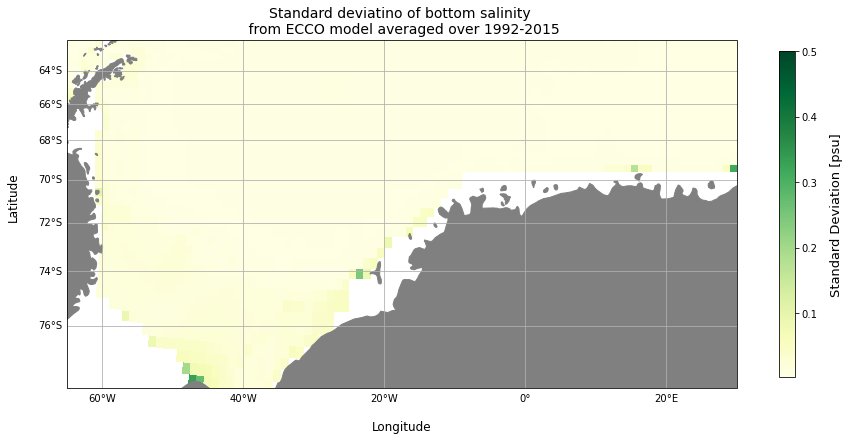

In [39]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_std_slt_wg.where(surface_mask), transform=ccrs.PlateCarree(), cmap='YlGn', vmax=0.5)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [psu]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)
ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviatino of bottom salinity \n from ECCO model averaged over 1992-2015', fontsize=14)
plt.savefig('std-bot-salt-ecco.pdf');

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity Z-score (start)

## <span style='color:Red'> Bottom Salinity Z-score (end)